In [1]:
import torch
import numpy as np
from PIL import Image, ImageDraw
from facenet_pytorch import MTCNN

c:\Users\cicil\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [3]:
mtcnn = MTCNN(
    image_size=320, margin=0, min_face_size=48,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

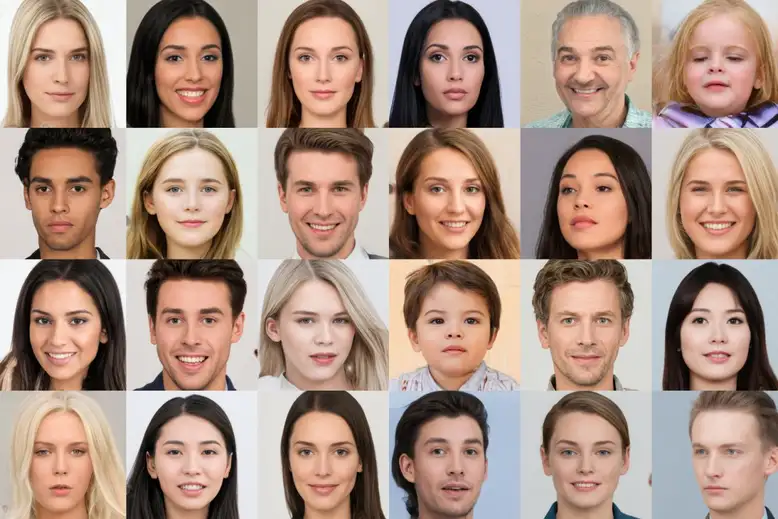

In [4]:
# Load a PIL Image
img = Image.open('datasets/faces.png')
img

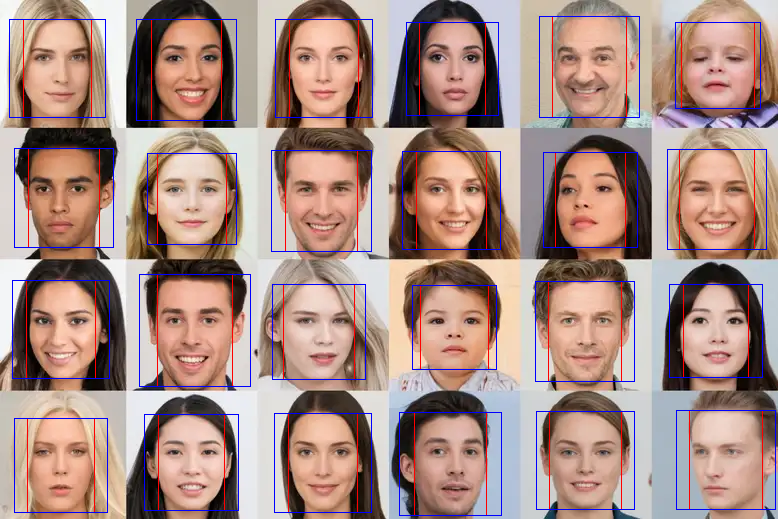

In [5]:
img_with_rects = img.copy()
cropped_faces = []

boxes, accuracy = mtcnn.detect(img)
for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box
    width = x2 - x1
    height = y2 - y1
    # Draw a red rectangle around the face
    draw = ImageDraw.Draw(img_with_rects)
    draw.rectangle((x1, y1, x2, y2), outline='red')

    # Extend the boundaries so that they are square
    if width > height:
        y1 -= (width - height) // 2
        y2 += (width - height) // 2
    else:
        x1 -= (height - width) // 2
        x2 += (height - width) // 2
    # Save the cropped faces
    cropped_face = img.crop((x1, y1, x2, y2))
    cropped_faces.append(cropped_face)
    # Draw a blue rectangle around the new boundaries
    draw.rectangle((x1, y1, x2, y2), outline='blue')
img_with_rects

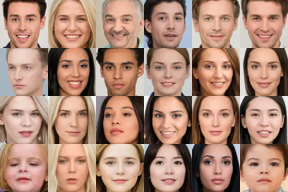

In [6]:
# Make a collage of the 24 cropped faces
resized_faces = []
image_size = 48
images_per_row = 6
collage = Image.new('RGB', (image_size * images_per_row, image_size * 4))
for i, face in enumerate(cropped_faces):
    x = (i % images_per_row) * image_size
    y = (i // images_per_row) * image_size
    resized_face = face.resize((image_size, image_size))
    resized_faces.append(resized_face)
    collage.paste(resized_face, (x, y))
collage

In [7]:
# Convert the resized faces to grayscale
grayscale_faces = []
for face in resized_faces:
    grayscale_face = face.convert('L')
    grayscale_faces.append(grayscale_face)

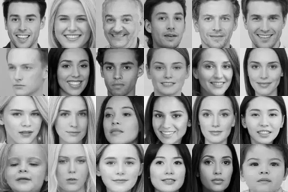

In [8]:
# Make a collage out of the gray faces
grayscale_collage = Image.new('L', (image_size * images_per_row, image_size * 4))
for i, face in enumerate(grayscale_faces):
    x = (i % images_per_row) * image_size
    y = (i // images_per_row) * image_size
    grayscale_collage.paste(face, (x, y))
grayscale_collage

In [9]:
# Convert the grayscale faces to tensors
grayscale_tensors = []
for face in grayscale_faces:
    array = np.array(face)
    tensor = torch.from_numpy(array).float().unsqueeze(0)
    # Divide by 255 to convert to a range of 0-1
    tensor = tensor / 255.0
    # Normalize the tensor
    tensor = (tensor - 0.5) / 0.255
    grayscale_tensors.append(tensor)

In [10]:
# Put them all in a big tensor
grayscale_tensor = torch.stack(grayscale_tensors)
grayscale_tensor = grayscale_tensor.to(device)
print(grayscale_tensor.shape)

torch.Size([24, 1, 48, 48])


In [11]:
# Load my FER model
from neural_net import FacialRecognitionNetwork

model = FacialRecognitionNetwork()
model.load_state_dict(torch.load('models/convo.pt'))
model = model.to(device)

Running on GPU (NVIDIA GeForce GTX 1050)


In [12]:
# Run the model on the grayscale faces
from data_loader import EMOTION
predictions = model(grayscale_tensor)
results = []
for prediction in predictions:
    # Get the max index in this prediction
    _, max_index = torch.max(prediction, 0)
    result = EMOTION[max_index.item()]
    results.append(result)
    

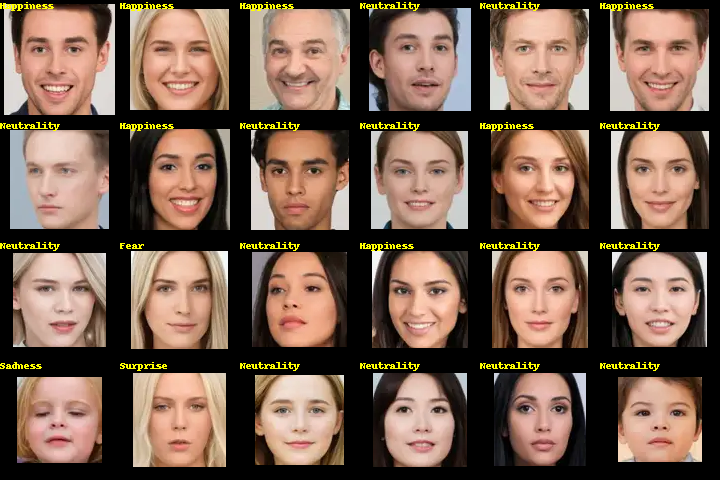

In [13]:
# Make a collage with the original cropped faces
image_size = 120
collage = Image.new('RGB', (image_size * images_per_row, image_size * 4))
for i, face in enumerate(cropped_faces):
    x = (i % images_per_row) * image_size
    y = (i // images_per_row) * image_size
    # Center the image in the collage box
    nx = (image_size - face.width) // 2 + x
    ny = (image_size - face.height) // 2 + y

    collage.paste(face, (nx, ny))
    
    # Paste the result text into the collage
    draw = ImageDraw.Draw(collage)
    draw.text((x, y), results[i], fill='yellow')

collage